In [ ]:
import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

## Reading the Dataset

In [ ]:
# Reading the dataset
data_csv = "/content/dataset.csv"
df = pd.read_csv(data_csv)
print('Dataset shape: ', df.shape)
print(df.dtypes)
df.head()

Dataset shape:  (1089, 7)
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-31,1196.400024,1212.400024,1182.000000,1201.900024,1201.900024,124.0
1,2014-01-02,1204.300049,1227.300049,1204.300049,1225.000000,1225.000000,209.0
2,2014-01-03,1221.699951,1239.000000,1221.699951,1238.400024,1238.400024,142.0
3,2014-01-06,1232.800049,1247.000000,1221.900024,1237.800049,1237.800049,127.0
4,2014-01-07,1239.300049,1242.400024,1226.300049,1229.400024,1229.400024,73.0


## Preprocessing

In [ ]:
# Verifying null values and deleting name from dataset
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head())
# Drop the lines with null values
df = df.dropna()
# Drop Date column
# df.pop("Date")

print('Dataset shape: ', df.shape)

     Open  High  Low  Close  Adj Close  Volume
127   NaN   NaN  NaN    NaN        NaN     NaN
230   NaN   NaN  NaN    NaN        NaN     NaN
248   NaN   NaN  NaN    NaN        NaN     NaN
515   NaN   NaN  NaN    NaN        NaN     NaN
535   NaN   NaN  NaN    NaN        NaN     NaN
Dataset shape:  (1081, 7)


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000
mean,1239.990935,1245.948751,1234.181223,1240.121092,1240.121092,5710.888992
std,72.099380,71.958409,72.366352,72.285649,72.285649,30312.863258
min,1053.699951,1062.000000,1046.199951,1050.800049,1050.800049,0.000000
25%,1196.199951,1202.500000,1188.000000,1195.599976,1195.599976,41.000000
50%,1251.000000,1256.000000,1244.800049,1250.800049,1250.800049,138.000000
75%,1293.400024,1299.800049,1288.000000,1294.199951,1294.199951,415.000000
max,1386.099976,1391.400024,1372.199951,1379.000000,1379.000000,290889.000000


In [ ]:
print("Minimum: {}\nMaximum: {}\nMean: {}\nMedian: {}\nSD: {}\nSkewness: {}\nKurtosis: {}".format(df["Low"].min(), df["High"].max(), 
df["Open"].mean(), df["Open"].median(), df["Open"].std(), df["Open"].skew(), df["Open"].kurtosis()))

Minimum: 1046.199951
Maximum: 1391.400024
Mean: 1239.9909346142476
Median: 1251.0
SD: 72.09937994027125
Skewness: -0.5455305158449637
Kurtosis: -0.3520037164214358


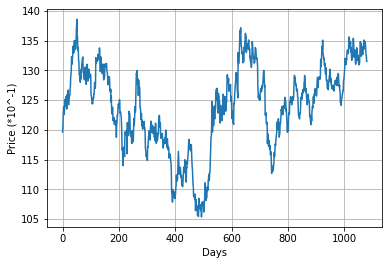

In [ ]:
lastday_2017 = df.loc[df["Date"]=="2017-12-29"].index.values[0]
df = df["Open"].values


plt.figure()
plt.plot(df/10)
plt.xlabel("Days")
plt.ylabel("Price (*10^-1)")
plt.grid()
plt.show()

## Normalizing
for homogenizing the variability and stability of the patterns and reducing exponential trend.

In [ ]:
# Transforming the dataset to ln scale
df = np.log(df)

# # Split dataset into train and test
train_set = df[0:lastday_2017]
test_set = df[lastday_2017:]
print("Train: ", train_set.shape, "Test: ", test_set.shape)
lastday_2017

Train:  (1007,) Test:  (74,)


1007

In [ ]:
print(train_set)

[7.08707235 7.0936538  7.10799857 ... 7.1856143  7.18531127 7.17747701]


In [ ]:
print(test_set)

[7.1856143  7.18318761 7.19127875 7.19376093 7.19623705 7.19210683
 7.19300939 7.19173051 7.19728568 7.21222074 7.21251572 7.20904434
 7.19945424 7.19855748 7.20325674 7.20674814 7.19376093 7.19908067
 7.1894696  7.18318761 7.18606862 7.1882617  7.18879031 7.19503731
 7.20934026 7.21081845 7.206674   7.19052534 7.18690102 7.19142933
 7.19668657 7.19421156 7.1818961  7.17808773 7.18105952 7.18803502
 7.18659838 7.19900596 7.18901682 7.18295987 7.18493238 7.18984677
 7.18705226 7.18295987 7.17785873 7.17732431 7.17862174 7.17961282
 7.19037454 7.20281007 7.20674814 7.20117088 7.20414929 7.18841274
 7.19067603 7.20072337 7.19428673 7.19556234 7.19029917 7.19518732
 7.19683634 7.2004995  7.20874833 7.19736052 7.20117088 7.20637729
 7.20303343 7.20682228 7.20228883 7.19593723 7.1902238  7.18841274
 7.18212409 7.18182009]


## Labels of an LSTM network
the LSTM network needs to predict the next day gold price closing value, this way a matrix of 2 dimensions will suffice for this problem.

# Regression models

### Forward Feed Neural Network (FFNN)
1 hidden layer with 3, 3 and 5 neurons for F = 4; 6 and 9, respectively

In [ ]:
# FFNN class
class FFNN:
    def __init__(self, input_dim, scaler=None):
        self.scaler = scaler 
        optimizer = Adam() ## ADAM optimizer
        ## if input dimension == 4 then hidden nodes = 3
        ## else if input dimension == 6 then hidden nodes =5
        h_n = 3 if input_dim == 4 or input_dim == 6 else 5
        self.model = Sequential() ## sequetial model
        self.model.add(Dense(h_n, input_dim=input_dim)) 
        self.model.add(Dense(1)) ## 1 dense layer
        ## metrics used: mse, accuracy, mae
        self.model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy", "mean_absolute_error"])
    
    def fit(self,x_train,y_train):
        if self.scaler:
            ## splitting into x and y
            x_train = self.scaler.transform(x_train)
            y_train = self.scaler.transform(y_train)

        ## fitting the model
        self.model.fit(x_train, y_train,verbose=0)

    ## predict function
    def predict(self, x_test):
        if self.scaler:
            x_test = self.scaler.transform(x_test)
            
        y_valid_pred = self.model.predict(x_test)
        
        if self.scaler:
            y_valid_pred = self.scaler.transform(y_valid_pred)

        return y_valid_pred.flatten()

## LSTM Model

- LSTM1 
  - LSTM layer with 100 units
- LSTM2 
  - LSTM layer with 200 units
- LSTM3 
  - LSTM layer with 100 units
  - LSTM layer with 50 units
- LSTM4 
  - LSTM layer with 100 units
  - LSTM layer with 100 units
  - Fully connected layer with 32 neurons

In [ ]:
# LSTM class
class PLSTM:
    def __init__(self, input_shape, model_type, scaler=None):
        self.scaler = scaler 
        optimizer = Adam() ## Adam Optimizer
        self.model = Sequential() ## Sequential Model
        self.h_n1 = 100 if model_type in [1,3,4] else 200 ## Hidden Nodes
        return_seq = True if model_type>2 else False
        self.model.add(LSTM(units=self.h_n1, input_shape=(input_shape[1], 1), return_sequences=return_seq))
        if model_type>2:
            self.h_n2 = 50 if model_type == 3 else 100
            self.model.add(LSTM(units=self.h_n2)) ## LSTM layer
            if type==4:
                self.model.add(Dense(32)) ## Dense layer 32
        self.model.add(Dense(1)) ## Dense Layer 1
        self.model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy", "mean_absolute_error"])
    
    def fit(self,x_train,y_train):
        if self.scaler:
            x_train = self.scaler.transform(x_train)
            y_train = self.scaler.transform(y_train)

        # reshape the entry as a 3D matrix with samples, timestamps and lastly features
        # instead of only samples and features as usual.
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        history = self.model.fit(x_train, y_train,epochs=50,batch_size=128,verbose=0)

    def predict(self, x_test):
        if self.scaler:
            x_test = self.scaler.transform(x_test)
            
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        y_valid_pred = self.model.predict(x_test)
        
        if self.scaler:
            y_valid_pred = self.scaler.transform(y_valid_pred)

        return y_valid_pred.flatten()

## CNN-LSTM Model

- CNN–LSTM1 
  - Convolutional layer with 32 filters of size (2,)
  - Convolutional layer with 64 filters of size (2,)
  - Max pooling layer with size (2,)
  - LSTM layer with 100 units
- CNN–LSTM2 
  - Convolutional layer with 64 filters of size (2,)
  - Convolutional layer with 128 filters of size (2,)
  - Max pooling layer with size (2,)
  - LSTM layer with 200 units
  - Fully connected layer with 32 neurons

- Activation : relu
- Convlulution 1D
- MaxPooling Layer

In [ ]:
# CNN-LSTM class
class CNNLSTM:
    def __init__(self, input_shape, model_type, scaler=None):
        self.scaler = scaler
        optimizer = Adam()
        self.model = Sequential()
        self.h_n1 = 100 if model_type == 1 else 200
        self.filter1 = 32 if model_type == 1 else 64
        self.filter2 = 64 if model_type == 1 else 128
        
        self.model.add(Conv1D(self.filter1, 2,activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=(input_shape[1],
                                   1)))

        self.model.add(Conv1D(self.filter2, 2,
                   activation='relu',
                   strides=1,
                   padding='same',
                   input_shape=(input_shape[1],
                                1)))

        self.model.add(MaxPooling1D(pool_size=2, padding='valid'))
        self.model.add(LSTM(units=self.h_n1, input_shape=(input_shape[1],1)))
    
        if type==2:
            self.model.add(Dense(32))
        self.model.add(Dense(1))
        self.model.compile(loss="mean_squared_error", optimizer=optimizer)
    
    def fit(self,x_train,y_train):
        if self.scaler:
            x_train = self.scaler.transform(x_train)
            y_train = self.scaler.transform(y_train)
            
        # reshape the entry as a 3D matrix with samples, timestamps and lastly features
        # instead of only samples and features as usual.
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        
        self.model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=128,
                        verbose=0
                      )

    def predict(self, x_test):
        if self.scaler:
            x_test = self.scaler.transform(x_test)
            
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        y_valid_pred = self.model.predict(x_test)
        
        if self.scaler:
            y_valid_pred = self.scaler.transform(y_valid_pred)

        return y_valid_pred.flatten()

In [ ]:
def create_models(entry_shape, scaler=None):
    # SVR
    svr = SVR(kernel='rbf', C=1, tol=1e-3)

    # FFNN
    ffnn = FFNN(entry_shape[1], scaler)

    # LSTM1
    lstm1 = PLSTM(entry_shape, 1, scaler)

    # LSTM2
    lstm2 = PLSTM(entry_shape, 2, scaler)

    # LSTM3
    lstm3 = PLSTM(entry_shape, 3, scaler)

    # LSTM4
    lstm4 = PLSTM(entry_shape, 4, scaler)

    # CNN-LSTM1
    cnnlstm1 = CNNLSTM(entry_shape, 1, scaler)

    # CNN-LSTM2
    cnnlstm2 = CNNLSTM(entry_shape, 2, scaler)

    labels = ["SVR", "FFNN", "LSTM1", "LSTM2", "LSTM3", "LSTM4", "CNN-LSTM1", "CNN-LSTM2"]
    models = [svr, ffnn, lstm1, lstm2, lstm3, lstm4, cnnlstm1, cnnlstm2]

    return labels, models

## Rolling window approach
The paper states that in order to predict the next day gold price, the model uses the $n$ past days gold prince, where $n$ stands for the time horizon used. Thus to generate a dataset with this specifications, we will use a rolling window algorithm to generate a window of features to a window of labels ( with in this case is equal to 1). This rolling window procedure works as follows:

Features: $[n1, n2, n3, n4, n5]$ -> Label $[n6]$

Converts an array into a matrix with size (n_windows, window size)
- col1   = 1:step:n - width + 1;
- row1   = 0:width - 1;
- index  = col1.' + row1;

In [ ]:
def rolling_window_mtx(x, window_size):
        """Compute all overlapping (rolling) observation windows over a vector 
            and return a matrix

        Args:
            x           : observation vector that is supposed to be split into
                          overlapping windows
            window_size : the target window size

        Returns:

            Window matrix with all windows as rows. That is, if n_windows is the
            number of windows, the result has dimensions:

            (n_windows, window_size)

        """
        if window_size < 1:
            raise ValueError("`window_size` must be at least 1.")
        if window_size > x.shape[-1]:
            raise ValueError("`window_size` is too long.")

        
        shape = x.shape[:-1] + (x.shape[-1] - window_size + 1, window_size)
        strides = x.strides + (x.strides[-1],)

        return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

In [ ]:
def generate_feat_labels_per_horizon(time_horizon, df, verbose=False):

    # Get the feature and label to the prediction task 
    feature_mtx = rolling_window_mtx(df, time_horizon)[:-1]
    label_mtx   = rolling_window_mtx(df[time_horizon:], 1)
    index_mtx   = rolling_window_mtx(np.arange(len(df)), time_horizon)

    if verbose:
        # Now we have a set of windows of the real coordinate
        # Lets take a look in one window
        print(f"\n One feature window: \n {feature_mtx[0]}")
        print(f"\n One label window: \n {label_mtx[0]}")
        print(f"\n Original dataset: \n {df[0:5]}")

    # For the classification task (if the gold values goes up or down)
    # We need to get a window of size 2, and then calculate the difference
    # If positive, the gold value went up.
    class_label_mtx = rolling_window_mtx(df[time_horizon-1:], 2)
    func = lambda x: True if x > 0 else False
    class_func = np.vectorize(func)
    class_label_mtx = class_func(np.diff(class_label_mtx).flatten()).reshape(len(class_label_mtx),1)
   
    if verbose:
    
        print(f"\n One window of class label (If tomorrow price is larger than today's price): \n {class_label_mtx[0]}")
    
    return feature_mtx, label_mtx, class_label_mtx

In [ ]:
label_index_mtx = rolling_window_mtx(np.arange(len(df))[4:], 1)
index_mtx   = rolling_window_mtx(np.arange(len(df)), 4)[:-1]

In [ ]:
train_idx = lastday_2017 - 4
index_mtx[train_idx], label_index_mtx[train_idx]

(array([1003, 1004, 1005, 1006]), array([1007]))

## Normalizing dataset

In [ ]:
df = df.reshape(len(df),1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df)
df = df.flatten()
df

array([7.08707235, 7.0936538 , 7.10799857, ..., 7.18841274, 7.18212409,
       7.18182009])

## Training the models for entries 4, 6 and 9 (days)

In [ ]:
entries = [4, 6, 9]
models = []
labels = []
history = []
for entry in entries:
    #Creating dataset
    feature_mtx, label_mtx, class_label_mtx = generate_feat_labels_per_horizon(entry, df)
    print(feature_mtx, label_mtx, class_label_mtx)
    scaler_input = MinMaxScaler(feature_range=(-1, 1))
    print(scaler_input)
    scaler_input.fit(feature_mtx)
    scaler_output = MinMaxScaler(feature_range=(-1, 1))
    print(scaler_output)
    scaler_output.fit(label_mtx)
    train_idx = lastday_2017 - entry
    train_x = feature_mtx[:train_idx]
    train_y = label_mtx[:train_idx]
    print("Training X shape: ",train_x.shape)
    print("Training Y shape: ",train_y.shape)
    tmp_labels, tmp_models = create_models(train_x.shape)#, scaler)
    for i in range(len(tmp_models)):
        print(tmp_labels[i])
        tmp_models[i].fit(train_x, train_y)
    models.append(tmp_models)
    labels.append(tmp_labels)
    print("\n=========================================================================\n")

[[7.08707235 7.0936538  7.10799857 7.11704332]
 [7.0936538  7.10799857 7.11704332 7.12230202]
 [7.10799857 7.11704332 7.12230202 7.11273486]
 ...
 [7.20682228 7.20228883 7.19593723 7.1902238 ]
 [7.20228883 7.19593723 7.1902238  7.18841274]
 [7.19593723 7.1902238  7.18841274 7.18212409]] [[7.12230202]
 [7.11273486]
 [7.11134901]
 ...
 [7.18841274]
 [7.18212409]
 [7.18182009]] [[ True]
 [False]
 [False]
 ...
 [False]
 [False]
 [False]]
MinMaxScaler(feature_range=(-1, 1))
MinMaxScaler(feature_range=(-1, 1))
Training X shape:  (1003, 4)
Training Y shape:  (1003, 1)
SVR
FFNN


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM1
LSTM2
LSTM3
LSTM4
CNN-LSTM1
CNN-LSTM2


[[7.08707235 7.0936538  7.10799857 7.11704332 7.12230202 7.11273486]
 [7.0936538  7.10799857 7.11704332 7.12230202 7.11273486 7.11134901]
 [7.10799857 7.11704332 7.12230202 7.11273486 7.11134901 7.11882625]
 ...
 [7.20637729 7.20303343 7.20682228 7.20228883 7.19593723 7.1902238 ]
 [7.20303343 7.20682228 7.20228883 7.19593723 7.1902238  7.18841274]
 [7.20682228 7.20228883 7.19593723 7.1902238  7.18841274 7.18212409]] [[7.11134901]
 [7.11882625]
 [7.1313787 ]
 ...
 [7.18841274]
 [7.18212409]
 [7.18182009]] [[False]
 [ True]
 [ True]
 ...
 [False]
 [False]
 [False]]
MinMaxScaler(feature_range=(-1, 1))
MinMaxScaler(feature_range=(-1, 1))
Training X shape:  (1001, 6)
Training Y shape:  (1001, 1)
SVR
FFNN


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM1
LSTM2
LSTM3
LSTM4
CNN-LSTM1
CNN-LSTM2


[[7.08707235 7.0936538  7.10799857 ... 7.11134901 7.11882625 7.1313787 ]
 [7.0936538  7.10799857 7.11704332 ... 7.11882625 7.1313787  7.13169851]
 [7.10799857 7.11704332 7.12230202 ... 7.1313787  7.13169851 7.12536352]
 ...
 [7.20874833 7.19736052 7.20117088 ... 7.20228883 7.19593723 7.1902238 ]
 [7.19736052 7.20117088 7.20637729 ... 7.19593723 7.1902238  7.18841274]
 [7.20117088 7.20637729 7.20303343 ... 7.1902238  7.18841274 7.18212409]] [[7.13169851]
 [7.12536352]
 [7.12230202]
 ...
 [7.18841274]
 [7.18212409]
 [7.18182009]] [[ True]
 [False]
 [False]
 ...
 [False]
 [False]
 [False]]
MinMaxScaler(feature_range=(-1, 1))
MinMaxScaler(feature_range=(-1, 1))
Training X shape:  (998, 9)
Training Y shape:  (998, 1)
SVR
FFNN


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LSTM1
LSTM2
LSTM3
LSTM4
CNN-LSTM1
CNN-LSTM2




In [ ]:
models = np.ravel(models)
labels = np.ravel(labels)
print(len(models))

24


## Helper functions for prediction and Metrics

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sb

def classification_pred(y):
    preds = []
    for i in range(1, len(y)):
        last_y = y[i - 1]
        curr_y = y[i]
        preds.append(curr_y - last_y > 0.0 )
    return np.array(preds)

# Metric functions
def get_metrics(y, pred_y):
    y_classification = classification_pred(y)
    y_pred_classification = classification_pred(pred_y)
    
    fpr, tpr, thresholds = roc_curve(y_classification, y_pred_classification)
    auc_value = auc(fpr, tpr)

    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i in range(len(y_classification)):
        is_y_pred_up = y_pred_classification[i]
        is_y_up = y_classification[i][0]

        if is_y_pred_up and is_y_up:
            tp += 1
        elif is_y_pred_up and not is_y_up:
            fp += 1
        elif not is_y_pred_up and not is_y_up:
            tn += 1
        else:
            fn += 1
    print("Classification report\n",classification_report(y_classification, y_pred_classification))
    return tp, tn, fp, fn, auc_value

## List of metrics for all the models for entries 4, 6 and 9

In [ ]:
# Testing models
index_model = 0
for entry in entries:
    print ("# Entries: ", entry)
    feature_mtx, label_mtx, class_label_mtx = generate_feat_labels_per_horizon(entry, df)
    scaler_input = MinMaxScaler(feature_range=(-1, 1))
    scaler_input.fit(feature_mtx)
    train_idx = lastday_2017 - entry
    test_x = feature_mtx[train_idx:]
    test_y = label_mtx[train_idx:]
    
    model_list = []
    MAE_list = []
    RMSE_list = []
    ACC_list = []
    AUC_list = []
    SEN_list = []
    SPE_list = []
    
    for i in range(index_model, index_model+8):
        test_y_estimative = models[i].predict(test_x)
        tp, tn, fp, fn, auc_value = get_metrics(test_y, test_y_estimative)
        
        model_list.append(labels[i])
        MAE_list.append(mean_absolute_error(test_y, test_y_estimative))
        RMSE_list.append(mean_squared_error(test_y, test_y_estimative, squared=True))
        ACC_list.append(((tp + tn) / (tp + tn + fp + fn))*100)
        AUC_list.append(auc_value)
        SEN_list.append(tp / (tp + fn))
        SPE_list.append(tn / (tn + fp))
        
    df_print = pd.DataFrame(list(zip(model_list, MAE_list,RMSE_list,ACC_list,AUC_list,SEN_list, SPE_list)),
           columns =['Model', 'MAE', 'RMSE', 'ACC (%)', 'AUC', 'SPEN', 'SPE'])
    df_print = df_print.sort_values(by=['ACC (%)'], ascending=False)
    print(df_print)
    print("\n==============================================================================\n")
        
    index_model += 8

# Entries:  4
Classification report
               precision    recall  f1-score   support

       False       0.39      0.38      0.39        34
        True       0.47      0.49      0.48        39

    accuracy                           0.44        73
   macro avg       0.43      0.43      0.43        73
weighted avg       0.44      0.44      0.44        73

Classification report
               precision    recall  f1-score   support

       False       0.40      0.41      0.41        34
        True       0.47      0.46      0.47        39

    accuracy                           0.44        73
   macro avg       0.44      0.44      0.44        73
weighted avg       0.44      0.44      0.44        73

Classification report
               precision    recall  f1-score   support

       False       0.36      0.38      0.37        34
        True       0.43      0.41      0.42        39

    accuracy                           0.40        73
   macro avg       0.40      0.40      0.40  

In [ ]:
model_list

['SVR', 'FFNN', 'LSTM1', 'LSTM2', 'LSTM3', 'LSTM4', 'CNN-LSTM1', 'CNN-LSTM2']